<a href="https://colab.research.google.com/github/hyo1happy/assignment/blob/master/vision/assignment1/renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
 rederer : This code is simple software renderer that will transform 
           an object's 3D coordinates into a 2D picture that is viewed from floting in space
           
 create   : 2019/10/01
 modified : 2019/10/03
"""

"\n rederer : This code is simple software renderer that will transform \n           an object's 3D coordinates into a 2D picture that is viewed from floting in space\n           \n create   : 2019/10/01\n modified : 2019/10/03\n"

In [0]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np # this is the only math library,
#you are allowed to import!!
from math import atan, sin, cos

In [0]:
def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]        
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]], 
                [p1[1], p2[1]])
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])
    plt.show()

In [0]:
def show_3d(vertices, edges):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]], 
                [p1[1], p2[1]], 
                [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

In [0]:
## global valiable
gVerbose = False # for debugging

#### 1. Define a cube as a numpy array with 8 corners

In [0]:
vertices = np.array([[-1, -1, -1],
                     [1, -1, -1],
                     [1, 1, -1],
                     [-1, 1, -1],
                     [-1, -1, 1],
                     [1, -1, 1],
                     [1, 1, 1],
                     [-1, 1, 1]])

edges = [(0,1), (2,3), (4,5), (6,7), 
         (0,3), (1,2), (4,7), (5,6),
         (0,4), (1,5), (2,6), (3,7)]

#### 2. Insert code that shows the cube using the function show_3d.

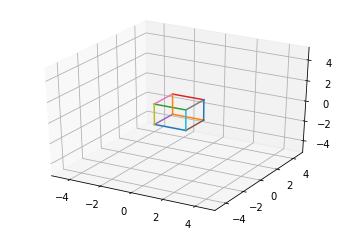

In [8]:
show_3d(vertices, edges)

#### 3. the extrinsic parameters of the camera

In [0]:
## to given camera position & orientation
camera_position = np.array([0, 0, -3])
camera_orientation = np.array([0, 0.1, 0])

In [0]:
## to/from homogenous function
# general addition dimention form (2D -> 3D -> 4d ...)
def to_homogenous(points, verbose=None):
    return_matrix = np.hstack([points, np.ones((points.shape[0], 1))])
    if verbose==True:
        print('to_homogenous{}->{} : \n{}\n->\n{}\n'.format(points.shape,return_matrix.shape,points,return_matrix))
    return return_matrix

# general reduced dimension form (4D -> 3D -> 2d ...)
def from_homogenous(points, verbose=None):
    return_matrix = points[:, :points.shape[1]-1]/points[:, points.shape[1]-1].reshape(-1,1)
    if verbose==True:
        print('from_homogenous{}->{} : \n{}\n->\n{}\n'.format(points.shape,return_matrix.shape,points,return_matrix))
    return return_matrix

In [0]:
## to return the final 4x4 extrinsic matrix that can convert homogenous coordinates
def get_extrinsic_matrix(position, orientation, verbose=None):
    # 1. making translation matrix
    I3x3 = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])
    c = -position
    T = np.vstack([np.hstack([I3x3, c.reshape(c.shape[0], 1)]), [0, 0, 0, 1]])
    if verbose==True:
        print('1. trans T{} : \n{}\n'.format(T.shape, T))
    # 2. making rotation matrix
    " fixed vector u & get theta"
    u = [0, 0, 0]
    theta = 0
    if orientation[0] != 0:
        u[0] = 1
        theta = orientation[0]
    elif orientation[1] != 0:
        u[1] = 1
        theta = orientation[1]
    elif orientation[2] != 0:
        u[2] = 1
        theta = orientation[2]
    ux = u[0]
    uy = u[1]
    uz = u[2]
    if verbose==True:
        print('2.1 vector u : {}\ntheta(radian) : {}\n'.format(u, theta))
    # making rotation matrix
    R3x3 = np.array([[cos(theta)+(ux**2)*(1-cos(theta)), ux*uy*(1-cos(theta))-uz*sin(theta), ux*uz*(1-cos(theta))+uy*sin(theta)],
                     [uy*uz*(1-cos(theta))+uz*sin(theta), cos(theta)+(uy**2)*(1-cos(theta)), uy*uz*(1-cos(theta))-uz*sin(theta)],
                     [uz*ux*(1-cos(theta))-uy*sin(theta), uz*uy*(1-cos(theta))+uz*sin(theta), cos(theta)+(uz**2)*(1-cos(theta))]])
    R = np.vstack([np.hstack([R3x3, np.zeros((R3x3.shape[0], 1))]), [0, 0, 0, 1]])
    return_matrix = np.dot(R, T)
    if verbose==True:
        print('2.2 rotation R{} : \n{}\n'.format(R.shape,R))
        print('2.3 extrinsic{} : \n{}\n'.format(return_matrix.shape, return_matrix))
    return return_matrix

In [0]:
extrinsic = get_extrinsic_matrix(camera_position, camera_orientation, verbose=gVerbose)

In [0]:
result_extrinsic = np.dot(extrinsic, to_homogenous(vertices, verbose=gVerbose).T)

#### 4. show the extrinsic result using show_3d.

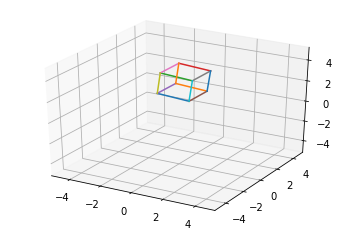

In [14]:
show_3d(result_extrinsic.T, edges)

#### 5. Make a function get_intrinsic_matrix(f,s) that creates the full intrinsic transformation including the projection matrix 3x4

In [0]:
## given scale f, point sx, sy value about intrinsic matrix
pixel = 200
f = 0.5
s = np.array([0.5, 0.5])
## define projection matrix 3x4
projection = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0]])

In [0]:
# making intrinsic matrix
def get_intrinsic_matrix(f, s, verbose=None):
    K = np.array([[f, 0, s[0]],
                  [0, f, s[1]],
                  [0, 0, 1]])
    if verbose==True:
        print('3. intrinsic K{} : \n{}'.format(K.shape, K))
    return K

In [0]:
intrinsic = get_intrinsic_matrix(f, s, verbose=gVerbose)

#### 6. transform the camera coordinates into 2D-coordinates.

In [0]:
## transform =  intrinsic * projection * rotation * translation * x
transform = np.dot(intrinsic, np.dot(projection, result_extrinsic))
## [x, y, w] => [x/w, y/w]
transform2D = from_homogenous(transform.T, verbose=gVerbose)

#### 7. multiply all points by 200.

In [0]:
pixelsx200 = transform2D * (pixel, pixel) # element-wise

#### 8. the image and plot the result using show_2d.

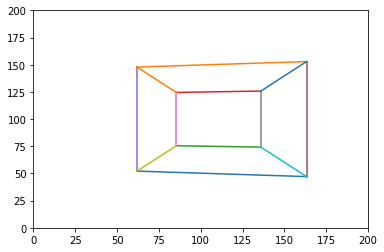

In [20]:
show_2d(pixelsx200, edges, (pixel, pixel))

In [0]:
vertices_decagon = np.array([[3,0, -10],
                     [-3,0, -10],
                     [-8,0, -6],
                     [-10,0, 0],
                     [-8,0, 6],
                     [-3,0, 10],
                     [3,0, 10],
                     [8,0, 6],
                    [10,0, 0],
                    [8,0, -6],
                    [3,15, -10],
                     [-3,15, -10],
                     [-8,15, -6],
                     [-10,15, 0],
                     [-8,15, 6],
                     [-3,15, 10],
                     [3,15, 10],
                     [8,15, 6],
                    [10,15, 0],
                    [8,15, -6]])
edges_decagon = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,0),
         (10,11),(11,12),(12,13),(13,14),(14,15),(15,16),(16,17),(17,18),(18,19),(19,10),
        (0,10),(1,11),(2,12),(3,13),(4,14),(5,15),(6,16),(7,17),(8,18),(9,19)]

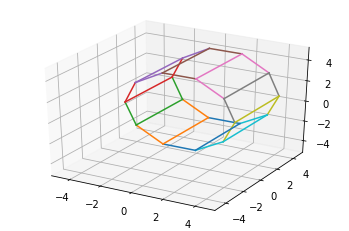

In [32]:
vertices_decagon = vertices_decagon * 0.35
show_3d(vertices_decagon, edges_decagon)

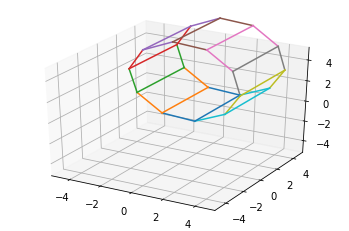

In [34]:
extrinsic1 = get_extrinsic_matrix(camera_position, camera_orientation, verbose=gVerbose)
result_extrinsic1 = np.dot(extrinsic1, to_homogenous(vertices_decagon, verbose=gVerbose).T)
show_3d(result_extrinsic1.T, edges_decagon)

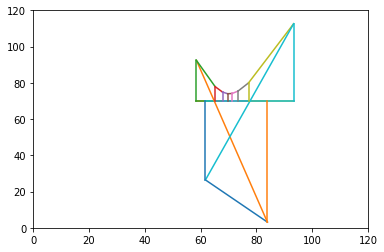

In [47]:
f = 0.5
s = np.array([7, 7])
intrinsic = get_intrinsic_matrix(f, s, verbose=gVerbose)
transform1 = np.dot(intrinsic, np.dot(projection, result_extrinsic1))
transform2D1 = from_homogenous(transform1.T, verbose=gVerbose)
pixelsx2001 = transform2D1 * (10, 10)
show_2d(pixelsx2001, edges_decagon, (120, 120))